In [1]:
%pylab inline

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import matplotlib as mpl
import numpy as np
mpl.rcParams['pdf.fonttype'] = 42
import scipy.stats
import sklearn.linear_model
import sklearn.ensemble

DATAPATH = "../data"

# Zscores file: chrom	start	end	ml_mu	ml_mu_se	pred_mu	predmu_se	zscore
zscores = pd.read_csv(os.path.join(DATAPATH, "alex_rough_mu_prediction.csv"))
zscores["diff"] = zscores["ml_mu"]-zscores["pred_mu"]
zscores["length"] = zscores["end"]-zscores["start"]+1
zscores = zscores[zscores["ml_mu_stderr"]!=0]

Populating the interactive namespace from numpy and matplotlib


# Plot score distributions

In [ ]:
# Calculate zscore
def GetZScore(x):
    num = x["ml_mu"]-x["pred_mu"]
    denom = np.sqrt(x["ml_mu_se"]**2/2 + x["pred_mu_se"]**2/2)
    return num/denom
zscores["zscore"] = zscores.apply(lambda x: GetZScore(x), 1)

KeyError: 'zscore'

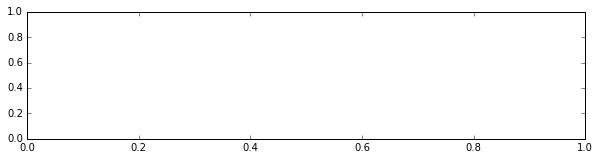

In [2]:
lb = -5
ub = 5
fig = plt.figure()
fig.set_size_inches((10, 5))

ax = fig.add_subplot(211)
ax.hist(zscores["zscore"], bins=np.arange(lb, ub, 0.1), edgecolor="black", color="white", normed=True);
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_xlabel("Z score", size=15)
ax.set_ylabel("Number of loci", size=15)
ax.axvline(x=0, linewidth=2, color="red")
# Fit normal
mu = np.mean(zscores["zscore"])
std = np.sqrt(np.var(zscores["zscore"]))
xvals = np.linspace(min(zscores["zscore"]), max(zscores["zscore"]), 100)
ax.set_xlim(left=lb, right=ub);
p = scipy.stats.norm.pdf(xvals, mu, std)
ax.plot(xvals, p, linewidth=2, color="green")

ax = fig.add_subplot(212)
ax.hist(zscores["diff"], bins=np.arange(lb, ub, 0.1),  edgecolor="black", color="white", normed=True );
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_xlabel("Diff", size=15)
ax.set_ylabel("Number of loci", size=15)
ax.axvline(x=0, linewidth=2, color="red")
# Fit normal
mu = np.mean(zscores["diff"])
std = np.sqrt(np.var(zscores["diff"]))
xvals = np.linspace(min(zscores["diff"]), max(zscores["diff"]), 100)
p = scipy.stats.norm.pdf(xvals, mu, std)
ax.plot(xvals, p, linewidth=2, color="green")

fig.tight_layout()

# Zscores/diff by STR set

In [478]:
# Get zscores by STR set
boxdata = []
diffdata = []
labels = []
meandiffs = []
meanzs = []
for strset in ["eSTRs.bed", "lobSTR_ref_GRCh37_intergenic.bed", "lobSTR_ref_GRCh37_intron.bed", \
              "lobSTR_ref_GRCh37_5utr.bed", "lobSTR_ref_GRCh37_3utr.bed", \
              "lobSTR_ref_GRCh37_coding.bed", \
               "lobSTR_ref_GRCh37_missenseconstrained.bed",  \
              "lobSTR_ref_GRCh37_pLI.bed",  
              "lobSTR_ref_GRCh37_IDgenes.bed"]:
    label = strset.split(".bed")[0].split("_")[-1]
    if label == "IDgenes":
        names = ["chrom","start","end","gene"]
    else: names = ["chrom","start","end"]
    setdata = pd.read_csv(os.path.join(DATAPATH, strset+".gz"), sep="\t", names=names)
    setdata = pd.merge(setdata, zscores, on=["chrom","start"]).drop_duplicates()
    setdata = setdata[setdata["ml_mu_se"]>0]
    print label, setdata.shape[0], np.mean(setdata["diff"]), scipy.stats.ttest_rel(setdata["ml_mu"], setdata["pred_mu"])
    meandiffs.append(np.mean(setdata["diff"]))
    meanzs.append(np.mean(setdata["zscore"]))
    boxdata.append(list(setdata["zscore"]))
    diffdata.append(list(setdata["ml_mu"]-setdata["pred_mu"]))
    labels.append(label)

eSTRs 1540 0.707472760315 Ttest_relResult(statistic=27.734063543106735, pvalue=1.2321465160553666e-137)
intergenic 129604 0.00390513678381 Ttest_relResult(statistic=1.3334419377835245, pvalue=0.18238916115670087)
intron 102159 0.0134137514115 Ttest_relResult(statistic=4.163371175345965, pvalue=3.1383971131171065e-05)
5utr 1230 -0.00443340231076 Ttest_relResult(statistic=-0.15411664692736282, pvalue=0.87754306561855144)
3utr 2216 0.0458358288508 Ttest_relResult(statistic=2.1377861849048183, pvalue=0.032643273014902788)
coding 699 -0.217571029194 Ttest_relResult(statistic=-5.5134525112824484, pvalue=4.9567847420199134e-08)
missenseconstrained 138 -0.298280011524 Ttest_relResult(statistic=-3.4368913725462855, pvalue=0.00077946584024718327)
pLI 217 -0.258312802524 Ttest_relResult(statistic=-3.7168445436576865, pvalue=0.00025700429676940063)
IDgenes 34 -0.354088926384 Ttest_relResult(statistic=-2.3870707255216237, pvalue=0.022869773097703341)


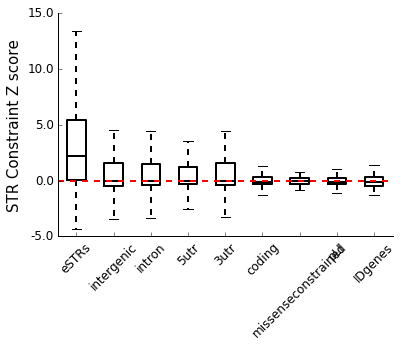

In [479]:
# Boxplot
fig = plt.figure()
ax = fig.add_subplot(111)
box = ax.boxplot(boxdata, sym="");
plt.setp(box['boxes'], color='black', linewidth=2)
plt.setp(box['whiskers'], color='black', linewidth=2)
plt.setp(box['medians'], color='black', linewidth=2)
plt.setp(box['caps'], color='black')
ax.axhline(y=0, linestyle="dashed", color="red",linewidth=2)
ax.set_ylabel("STR Constraint Z score", size=15)
ax.set_xticklabels(labels, size=12, rotation=45);
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

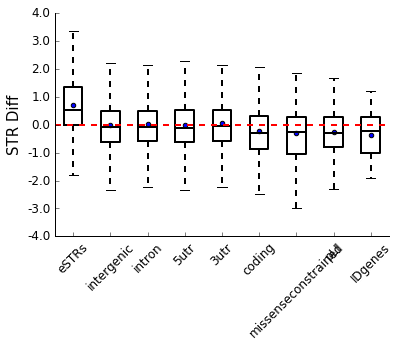

In [480]:
# Boxplot
fig = plt.figure()
ax = fig.add_subplot(111)
box = ax.boxplot(diffdata, sym="");
ax.scatter(ax.get_xticks(), meandiffs)
plt.setp(box['boxes'], color='black', linewidth=2)
plt.setp(box['whiskers'], color='black', linewidth=2)
plt.setp(box['medians'], color='black', linewidth=2)
plt.setp(box['caps'], color='black')
ax.axhline(y=0, linestyle="dashed", color="red",linewidth=2)
ax.set_ylabel("STR Diff", size=15)
ax.set_xticklabels(labels, size=12, rotation=45);
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# STRs vs. SNP constraint scores

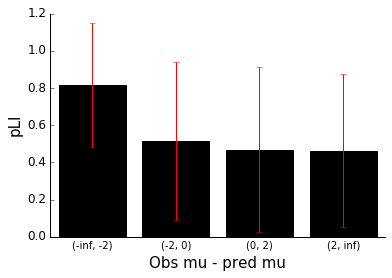

In [481]:
# Check out pLI scores
pLI = pd.read_csv(os.path.join(DATAPATH, "lobSTR_pLI_scores_coding.bed.gz"), sep="\t", names=["chrom","start","end","pLI"])
pLI = pd.merge(pLI, zscores, on=["chrom","start","end"]).drop_duplicates()
scores = []
bins = [(-1*np.inf, -2), (-2, 0), (0, 2), (2, np.inf)]
col="diff"
#bins = [(-2,-1),(-1,0),(0,1)]
#col = "zscore"
for b in bins:
    d = pLI[(pLI[col]>=b[0]) & (pLI[col]<b[1]) & (pLI["ml_mu_se"]>0)]
    scores.append(list(d["pLI"]))
  
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(scores)), map(lambda x: np.mean(x), scores), align="center", tick_label=bins, \
       color="black", ecolor="red",
      yerr=map(lambda x: np.sqrt(np.var(x)), scores));
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_xlabel("Obs mu - pred mu", size=15)
ax.set_ylabel("pLI", size=15)
ax.set_yticklabels(ax.get_yticks(), size=12);

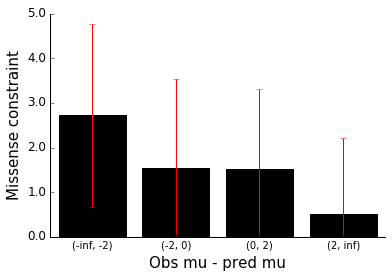

In [482]:
# Check out missense constraint scores
ms = pd.read_csv(os.path.join(DATAPATH, "lobSTR_missense_scores_coding.bed.gz"), sep="\t", names=["chrom","start","end","ms"])
ms = pd.merge(ms, zscores, on=["chrom","start","end"]).drop_duplicates()
scores = []
bins = [(-1*np.inf, -2), (-2, 0), (0, 2), (2, np.inf)]
col="diff"
#bins = [(-2,-1),(-1,0),(0,1)]
#col = "zscore"
for b in bins:
    d = ms[(ms[col]>=b[0]) & (ms[col]<b[1])& (ms["ml_mu_se"]>0)]
    scores.append(list(d["ms"]))
  
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(scores)), map(lambda x: np.mean(x), scores), align="center", tick_label=bins, \
       color="black", ecolor="red",
      yerr=map(lambda x: np.sqrt(np.var(x)), scores));
ax.set_ylim(bottom=0, top=5);
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_xlabel("Obs mu - pred mu", size=15)
ax.set_ylabel("Missense constraint", size=15)
ax.set_yticklabels(ax.get_yticks(), size=12);